In [1]:
import h5py
import cv2
import scipy.io as sio
from scipy import misc
import numpy as np
# import matplotlib.pyplot as plt
# %matplotlib inline
import PIL
from PIL import Image
import pandas as pd
from random import shuffle
import os
import random
import pickle
import keras
from keras.utils import * 

Using TensorFlow backend.


In [2]:
class DigitStructure:
    
    def __init__(self, _filePath):
        
        self.loadFile = self.load_datafile(_filePath)
        self.digitStruct = self.readDigitStruct(self.loadFile)
        self.name = self.digitStruct['name']
        self.boxLabels = self.digitStruct["bbox"]
        
    def load_datafile(self, filepath):
        
        return h5py.File(filepath,'r')
    
    def readDigitStruct(self, datafile):
        
        return datafile["digitStruct"]
    
    def getImageName(self, index):
        
        names = []
        for i in self.loadFile[self.name[index][0]].value:
            names.append(chr(i[0]))
        return ''.join(names)
    
    def bboxExtractor(self, attr):
        
        if (len(attr) > 1):
            attr = [self.loadFile[attr.value[j].item()].value[0][0] for j in range(len(attr))]
        else:
            attr = [attr.value[0][0]]
        return attr
    
    # getBbox returns a dict of data for the n(th) bbox. 
    def getBboxAttributes(self,index):
        
        bbox = {}
        bb = self.boxLabels[index].item()
        bbox['height'] = self.bboxExtractor(self.loadFile[bb]["height"])
        bbox['label'] = self.bboxExtractor(self.loadFile[bb]["label"])
        bbox['left'] = self.bboxExtractor(self.loadFile[bb]["left"])
        bbox['top'] = self.bboxExtractor(self.loadFile[bb]["top"])
        bbox['width'] = self.bboxExtractor(self.loadFile[bb]["width"])
        
        return bbox
            
    def getDigitStructure(self,n):
        
        s = self.getBboxAttributes(n)
        
        s['name']=self.getImageName(n)
        return s

    # getAllDigitStructure returns all the digitStruct from the input file.     
    def getAllDigitStructure(self):
        
        struct = []
        for i in range(len(self.name)):
            struct.append(self.getDigitStructure(i))
        return struct
    
    def getAllDigitStructure_ByDigit(self):
        
        
        digitDictionary = self.getAllDigitStructure()
        result = []
        structCnt = 1
        for i in range(len(digitDictionary)):
            item = { 'filename' : digitDictionary[i]["name"] }
            digit_labels_in_each_image = []
            for j in range(len(digitDictionary[i]['height'])):
               number = {}
               number['height'] = digitDictionary[i]['height'][j]
               number['label']  = digitDictionary[i]['label'][j]
               number['left']   = digitDictionary[i]['left'][j]
               number['top']    = digitDictionary[i]['top'][j]
               number['width']  = digitDictionary[i]['width'][j]
               digit_labels_in_each_image.append(number)
            structCnt = structCnt + 1
            item['boxes'] = digit_labels_in_each_image
            result.append(item)
        return result
    

# Load Train Data

In [3]:
training_dataPath = './train/'
train_digitStruct = training_dataPath + 'digitStruct.mat'
digitStructure = DigitStructure(train_digitStruct)
training_data = digitStructure.getAllDigitStructure_ByDigit()

# Load Test Data

In [4]:
test_dataPath = './test/'
test_digitStructure = test_dataPath + 'digitStruct.mat'
digitStructure = DigitStructure(test_digitStructure)
testing_data = digitStructure.getAllDigitStructure_ByDigit()

/home/ramesh/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  import sys


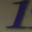

In [164]:
im = Image.open('./train/1.png')
# image_left = 
height  = 219.0
width  = 81.0
top  = 77.0
left = 246.0
img = misc.imresize(im.crop((left, top, width+left, height+top)), (32,32,1))
Image.fromarray(img, 'RGB')

In [55]:
len(training_data)

33402

In [98]:

class PreProcessDataSet:
    
    def __init__(self, data, path, num_of_digits):
        
        self.data = data
        self.path = path
        self.image_size = (32,32,1)
#         self.dataSet = \
#                 np.ndarray([len(self.data), 32, 32, 1], dtype = 'float32')
        self.num_classes = 10
#         self.total_digits = 6  #data set contains maximum 6 digits
        # initialize all elements with 10
#         self.labels = np.ones([len(self.data), self.total_digits], dtype=int) * 10

        # 73257 number of digits in all train images
        self.labels = np.zeros([num_of_digits, self.num_classes], dtype=int)
        self.images = []
        self.validation_index = []
        self.training_index = []
        self.count = 0
        
    
    def preProcess(self):
        
        for i in np.arange(len(self.data)):
            
            get_filename = self.data[i]["filename"]
            filename = self.path + get_filename
#             print filename
            read_image = Image.open(filename)
#             read_image.show()
            image_size = read_image.size
            
#             print self.data[i]['boxes']
            boxList = self.data[i]['boxes']
            number_of_digits = len(boxList)
#             self.labels[i, 0] = number_of_digits

#             print boxList
#             print "num of digits ", number_of_digits
            for digits in np.arange(number_of_digits):
                #if digits are less than 5
#                 print "self.count ", self.count
#                 print "boxList[digits]['label'] ", int(boxList[digits]['label'])
                # in dataset, digit 0 has label 10
                if int(boxList[digits]['label']) == 10:
                    self.labels[self.count, 0 ] = 1 
                else:
                    self.labels[self.count, int(boxList[digits]['label']) ] = 1 

                height = int(boxList[digits]['height']) 
                width = int(boxList[digits]['width'])
                top = int(boxList[digits]['top'])
                left = int(boxList[digits]['left'])
                self.count += 1
                cropped_digits = \
                    misc.imresize( (read_image.crop((left, top, width+left, height+top))), (32,32, 3))
                
                resized_image = Image.fromarray(cropped_digits)
                gray_image = resized_image.convert("L")
                gray_image = np.expand_dims(gray_image, -1)
                gray_image = self.normalization(gray_image)
#                 print gray_image.shape
                self.images.append(gray_image)
#                 print "self count ", self.count    
                
    
#             if self.count > 220:
#                 break
            
        return  self.images, self.labels
            
                
    def normalization(self, image):

        mean = np.mean(image, dtype='float32')
        standard_deviation = np.std(image, dtype='float32', ddof=1)

        if standard_deviation < 1e-4:
            standard_deviation = 1.

        image = (image - mean)/standard_deviation

        return image
    
    
    def createValidationSet(self, dataset, labels):
                
        
        split_portion = int(len(dataset) * 0.2)
    
        train_dataset, train_labels = self.shuffleSet(dataset, labels)
        valid_dataset = train_dataset[:split_portion]
        valid_labels = train_labels[:split_portion]
        
        train_dataset = train_dataset[split_portion:]
        train_labels = train_labels[split_portion:]
        
        return train_dataset, train_labels, valid_dataset, valid_labels
        
        
    def shuffleSet(self, data, labels ):
        
        permutation = np.random.permutation(labels.shape[0])
#         shuffled_dataset = data[permutation,:,:]
#         shuffled_labels = labels[permutation]

#         permutation = np.random.permutation(len(labels))
        shuffled_dataset = [data[i] for i in permutation]
        shuffled_labels = labels[permutation]
        
        return shuffled_dataset, shuffled_labels
        

In [99]:
poces = PreProcessDataSet(training_data, training_dataPath, num_of_digits = 73257)

In [100]:
images, labels = poces.preProcess()
#train_num_labels contains 10 classes, 0 to 9 and 10(represents no digit) 

/home/ramesh/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


In [101]:
len(images), labels.shape

(73257, (73257, 10))

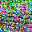

In [60]:
Image.fromarray(images[9],'RGB')

In [91]:
poces = PreProcessDataSet(training_data, training_dataPath, num_of_digits = 73257)

In [102]:
train_dataset, train_num_labels, valid_dataset, valid_labels = poces.createValidationSet(images, labels)

In [103]:
print len(train_dataset), len(train_num_labels), len(valid_dataset), len(valid_labels)

58606 58606 14651 14651


# Generate Test Data

In [104]:
poces = PreProcessDataSet(testing_data, test_dataPath, num_of_digits = 26032)

In [105]:
test_dataset, test_labels = poces.preProcess()
#test_dataset contains images in list
#test_labels contains labels of images in list

/home/ramesh/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


In [20]:
# test_labels  = np.asarray(test_labels)

In [106]:
len(test_dataset),  test_labels.shape

(26032, (26032, 10))

# Save in Pickle File

In [107]:
pickle_file = 'SVHN_list_single_digit.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_num_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise